# Activity Investigation

This should be helpful when I just want to look closely at the results of a particular activity stream

In [1]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities, get_clean_stream
from strava.data.cache import Cache

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()

pd.set_option('display.max_columns', 500)

In [2]:
# Create a cache
cache = Cache()

In [3]:
# Get a list of activities
activities = get_clean_activities()
activities.tail()

Existing access token is valid.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 200 activities.
-> Received page 4 with 36 activities.
-> Received page 5 with 0 activities.
...retrieved total of 636 activities.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
630,3425015993,Afternoon Ride,8964.6,0 days 00:26:43,0 days 00:26:43,39.0,693.8,654.7,Ride,2020-04-26 15:07:20,(GMT-07:00) America/Edmonton,"[53.636688, -113.587822]","[53.636729, -113.587903]",0,a3425015993,10.0,20.1312,40.32,165.0,185.0,{mjfIhhjtTt@fAf@|@HREZUpAe@pB{@vC]z@a@r@k@x@c@...,2020,1970-04-26 15:07:20
631,3425016238,Lunch Ride,17516.8,0 days 00:48:11,0 days 00:48:11,71.2,693.8,653.7,Ride,2020-04-25 11:48:43,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,21.8124,50.04,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...,2020,1970-04-25 11:48:43
632,3425017204,Afternoon Ride,14517.0,0 days 00:47:28,0 days 00:47:28,64.1,693.8,653.7,Ride,2020-04-23 13:02:13,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,18.3492,36.72,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...,2020,1970-04-23 13:02:13
633,3425016478,Afternoon Ride,17605.8,0 days 00:57:41,0 days 00:57:41,69.9,693.8,653.7,Ride,2020-04-22 14:48:16,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,18.3132,39.96,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...,2020,1970-04-22 14:48:16
635,3425016348,Afternoon Ride,7278.0,0 days 00:23:28,0 days 00:23:28,21.9,693.8,684.9,Ride,2020-04-16 13:57:58,(GMT-07:00) America/Edmonton,"[53.636894, -113.587782]","[53.636646, -113.587864]",0,a3425016348,10.0,18.6084,36.00,177.8,197.0,uojfIxhjtTvB|CjAnBbApBlA|CXdC^tEL`CB|ACtBKjBs@...,2020,1970-04-16 13:57:58


In [75]:
# Find the activity of interest
white_rock_route_activities = activities.query('year in [2023, 2025] & distance > 28000 & distance < 29000')
white_rock_route_activities

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,14218149073,Afternoon Ride,28507.2,0 days 01:17:43,0 days 01:19:52,352.0,100.6,3.4,Ride,2025-04-18 16:41:11,(GMT-08:00) America/Vancouver,"[49.055033, -122.7746]","[49.055058, -122.77465]",4,a14218149073,NaN,22.0068,59.1840,167.7,189.0,e_ljHpsjlVPUDFDbA`@x@JtAn@hCPhBh@x@F`BPh@LHjCG...,2025,1970-04-18 16:41:11
1,14208696270,Afternoon Ride,28463.9,0 days 01:11:30,0 days 01:13:01,352.2,100.6,3.4,Ride,2025-04-17 16:51:20,(GMT-08:00) America/Vancouver,"[49.055069, -122.774553]","[49.055062, -122.774649]",1,a14208696270,NaN,23.8860,59.6880,169.6,185.0,w`ljHltjlVH?VWRAPWHDCb@Dh@^x@N`Br@rCFfA\b@JVFz...,2025,1970-04-17 16:51:20
3,14180028159,Afternoon Ride,28424.2,0 days 01:13:00,0 days 01:16:48,352.8,100.6,3.4,Ride,2025-04-14 16:42:22,(GMT-08:00) America/Vancouver,"[49.055064, -122.774556]","[49.055044, -122.774662]",0,a14180028159,NaN,23.3640,58.3200,169.9,187.0,kaljHhujlVL`@Z`@ZI^o@HDT`@Bn@Lv@n@fCJzA\^HVD\@...,2025,1970-04-14 16:42:22
4,14169893236,Afternoon Ride,28489.4,0 days 01:14:38,0 days 01:17:33,353.1,100.6,3.4,Ride,2025-04-13 13:20:56,(GMT-08:00) America/Vancouver,"[49.055083, -122.774517]","[49.05505, -122.774656]",4,a14169893236,NaN,22.9032,58.3200,171.1,193.0,qaljH|tjlVf@lAZEd@m@JDRd@D`At@vCPfB^d@HTDZ@p@R...,2025,1970-04-13 13:20:56
5,14150724069,Afternoon Ride,28428.8,0 days 01:14:10,0 days 01:18:07,352.3,100.6,3.4,Ride,2025-04-11 17:06:43,(GMT-08:00) America/Vancouver,"[49.055099, -122.774567]","[49.055068, -122.7746]",0,a14150724069,NaN,22.9968,58.4640,168.5,185.0,o`ljHdtjlVXYP?RS?`A`@x@TjBn@lCHlAh@`AF\?t@Nr@X...,2025,1970-04-11 17:06:43
6,14132622357,Afternoon Ride,28429.9,0 days 01:15:12,0 days 01:17:03,347.6,100.6,3.4,Ride,2025-04-09 16:40:30,(GMT-08:00) America/Vancouver,"[49.055026, -122.774595]","[49.055085, -122.774611]",0,a14132622357,NaN,22.6836,55.8000,168.9,186.0,galjHrujlVRj@NLREd@o@PHJVRlBp@bCHrADPb@j@F\B`A...,2025,1970-04-09 16:40:30
8,14082982033,Afternoon Ride,28379.6,0 days 01:21:00,0 days 01:26:42,347.2,100.8,3.6,Ride,2025-04-04 17:30:50,(GMT-08:00) America/Vancouver,"[49.055036, -122.774603]","[49.055068, -122.774642]",0,a14082982033,10.0,21.0204,53.2800,158.4,182.0,galjHpujlVTj@PPXI^m@NFPh@PdBp@jCHnA`@f@HV@~@Lv...,2025,1970-04-04 17:30:50
132,10033794476,Afternoon Ride,28362.3,0 days 01:07:07,0 days 01:09:07,351.6,101.0,0.4,Ride,2023-10-13 16:35:18,(GMT-08:00) America/Vancouver,"[49.05503843910992, -122.77440589852631]","[49.05511471442878, -122.7746445313096]",3,a10033794476,NaN,25.3548,60.1128,165.4,187.0,oaljHbtjlVXlAZn@XKDg@LIp@b@RtBd@l@VnAh@bEDrAb@...,2023,1970-10-13 16:35:18
137,9996006537,Lunch Ride,28337.7,0 days 01:08:22,0 days 01:10:25,351.7,101.3,3.4,Ride,2023-10-07 11:58:04,(GMT-08:00) America/Vancouver,"[49.05492193065584, -122.77450765483081]","[49.05510381795466, -122.77460572309792]",3,a9996006537,NaN,24.8688,59.4288,165.3,187.0,kaljHfujlVt@lAv@u@l@^DtAXXp@tC?dAXbBRlBJLvCMBL...,2023,1970-10-07 11:58:04
138,9990461310,Afternoon Ride,28352.5,0 days 01:08:25,0 days 01:14:39,351.5,101.3,3.4,Ride,2023-10-06 16:39:06,(GMT-08:00) America/Vancouver,"[49.05519266612828, -122.7743857819587]","[49.0550793427974, -122.7746035438031]",2,a9990461310,NaN,24.8652,64.3896,162.5,185.0,kaljHfsjlV`@hBP`@NABu@RUl@r@JdAj@nAVrAJJRpBXtA...,2023,1970-10-06 16:39:06


In [76]:
# Manual selection of dates
activity_dates = [(2025, 4, 4), (2025, 4, 9), (2025, 4, 11), (2025, 4, 13), (2025, 4, 17), (2025, 4, 18)]
activity_dates = [datetime.date(*d) for d in activity_dates]

# Selection by Distance
activity_dates = white_rock_route_activities.start_date_local.apply(lambda x: x.date())
print(activity_dates.shape)
activity_streams = []
for ad in activity_dates:
    stream_df = get_clean_stream(activities, ad, cache)
    stream_df['ad'] = ad
    activity_streams.append(stream_df)

activity_streams_df = pd.concat(activity_streams)

(43,)
Found activity 14218149073 in cache.
Found activity 14208696270 in cache.
Found activity 14180028159 in cache.
Found activity 14169893236 in cache.
Found activity 14150724069 in cache.
Found activity 14132622357 in cache.
Found activity 14082982033 in cache.
Found activity 10033794476 in cache.
Found activity 9996006537 in cache.
Found activity 9990461310 in cache.
Found activity 9985137901 in cache.
Found activity 9978987119 in cache.
Found activity 9940528230 in cache.
Found activity 9911215580 in cache.
Found activity 9902256544 in cache.
Found activity 9851417814 in cache.
Found activity 9831605045 in cache.
Found activity 9824564333 in cache.
Found activity 9805624701 in cache.
Found activity 9765687810 in cache.
Found activity 9759475809 in cache.
Found activity 9753449004 in cache.
Found activity 9732826501 in cache.
Found activity 9721132382 in cache.
Found activity 9702570543 in cache.
Found activity 9681559117 in cache.
Found activity 9662971128 in cache.
Found activity

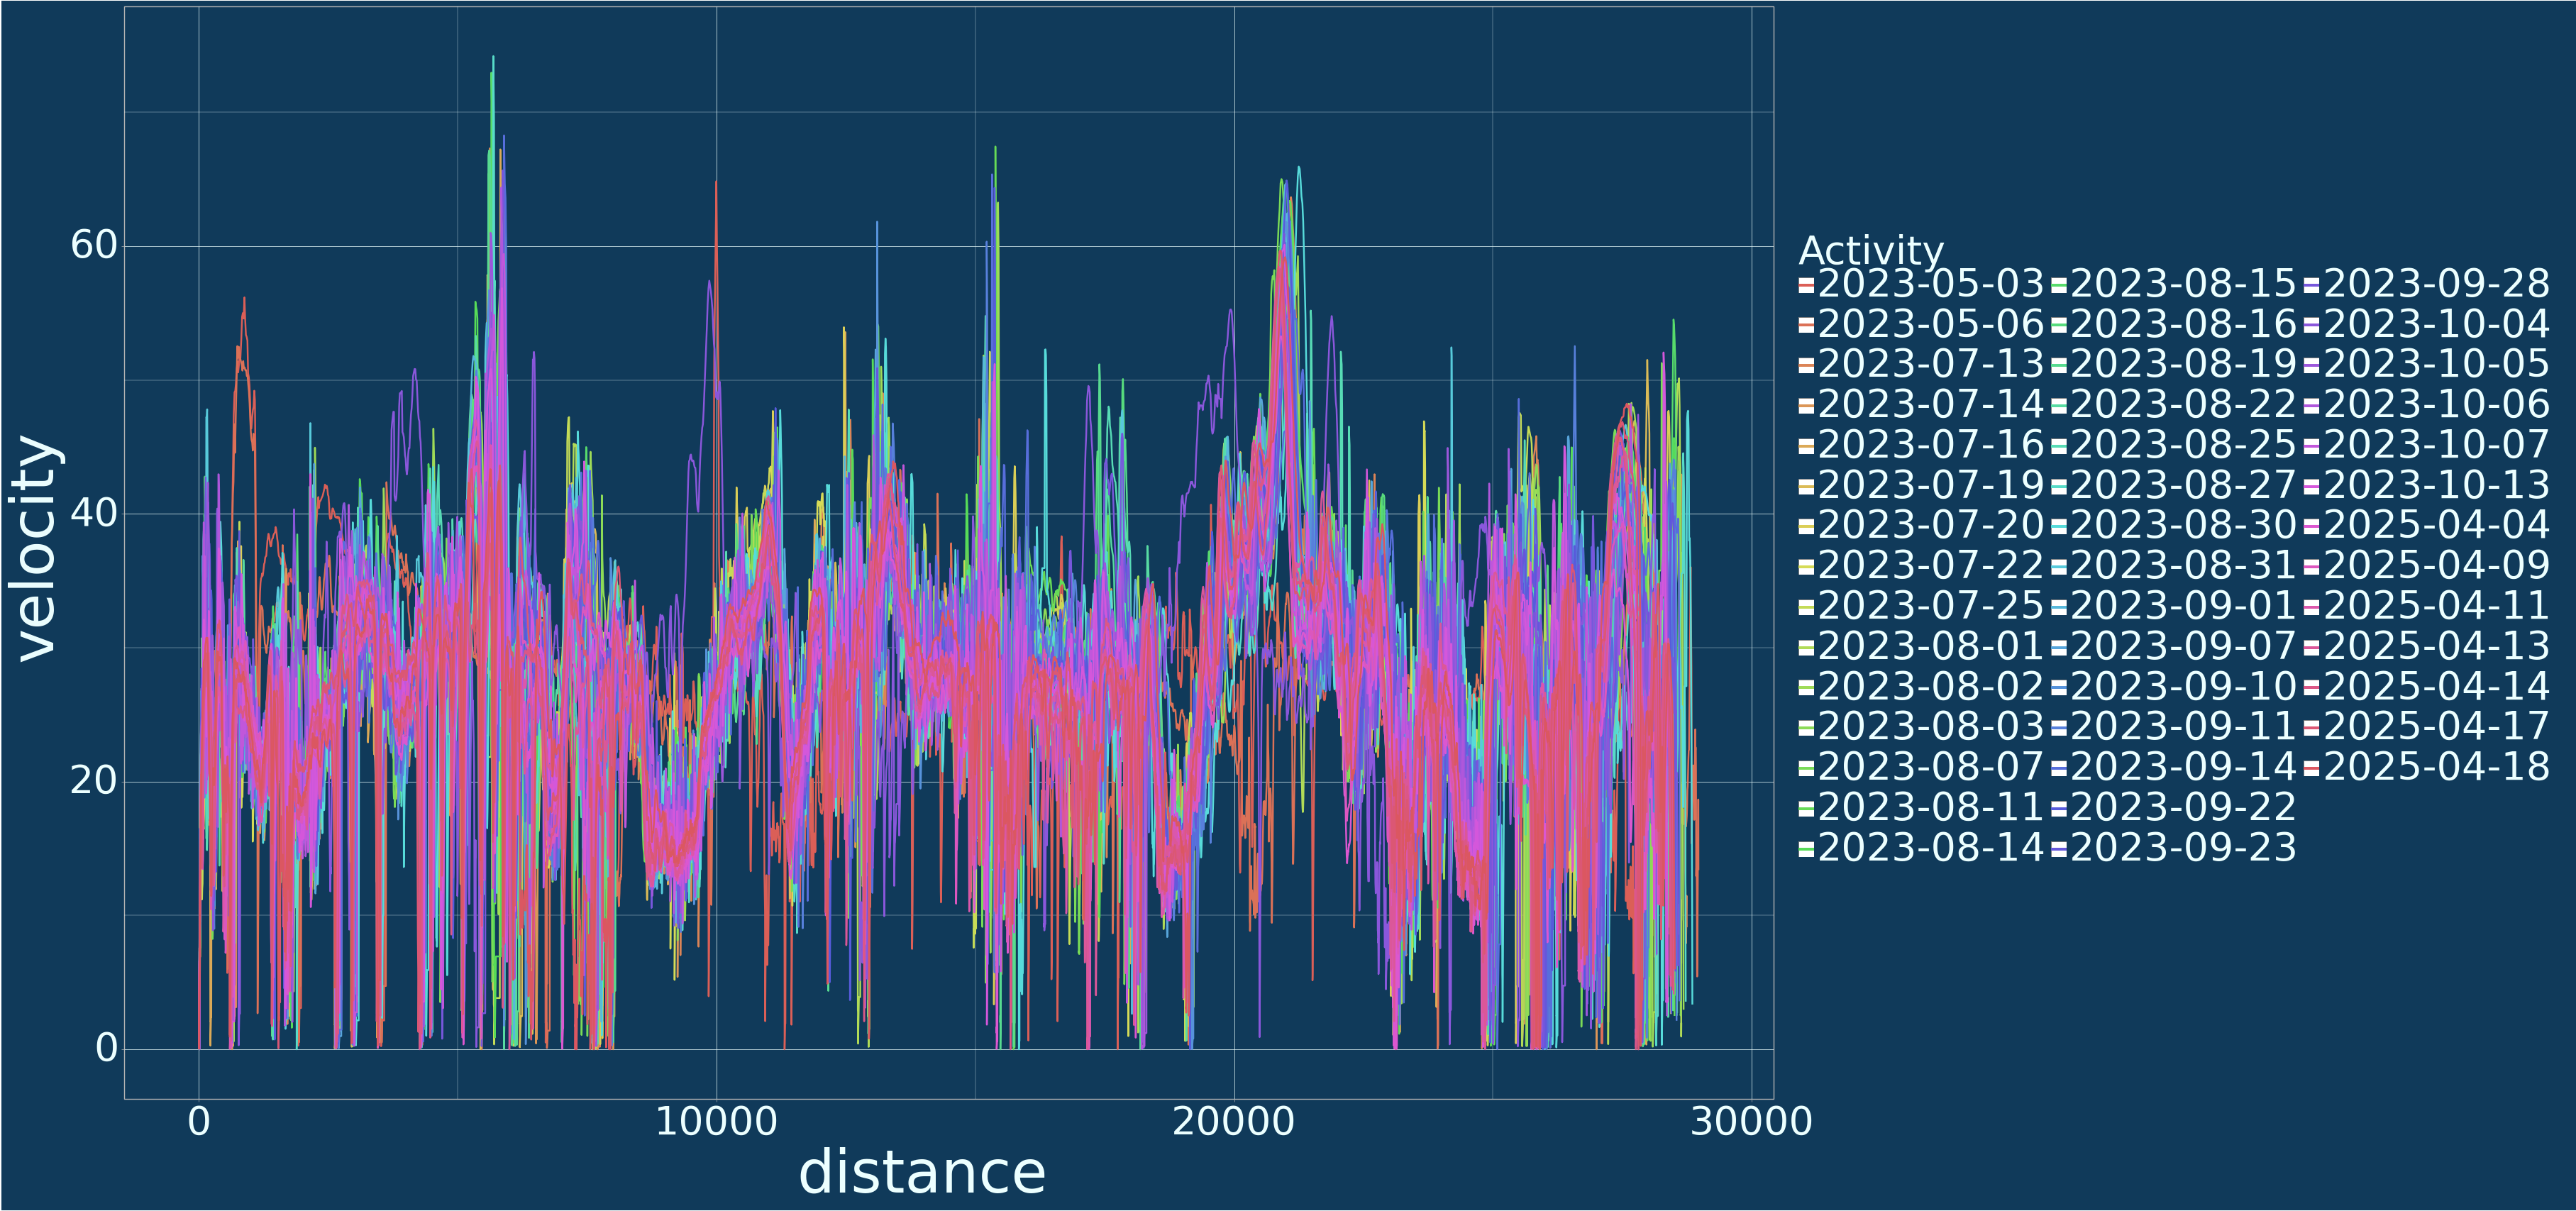

<ggplot: (812083996)>

In [78]:
pt.dark()
# velocity, distance, altitude, heartrate, time
(gg.ggplot(activity_streams_df, gg.aes(x='distance', y='velocity', colour='factor(ad)')) 
    + gg.geom_line(size=1)
    + gg.theme(figure_size=(14, 9))
    # + gg.scale_x_continuous(limits=[13000, 22000])
    + pt.gg_theme()
    + gg.theme(
        legend_background=gg.element_rect(fill=pt.background),
    )
    + gg.labs(colour='Activity')
    )

In [10]:
# A really cool thing would be to gather all similar efforts and see their correlation or average or something

In [ ]:
# Can make some sort of way to specify an activity, and it will search all previous activities for similar ones
# - Can do it just by distance, and/or elevation change